<a href="https://colab.research.google.com/github/JDslay/LKA/blob/main/DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import httpimport
url = "https://raw.githubusercontent.com/JDslay/LKA/main/resources"
with httpimport.remote_repo(["plotcm"], url):
    import plotcm
from google.colab import drive
drive.mount('/content/drive')
import time
import progressbar
from torch.utils.tensorboard import SummaryWriter


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# some functions needed for the analysis

# All predictions in one tensor
@torch.no_grad()  # gradients not needed while evaluation / saves memory if turned off
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Number of correct predictions
def get_nbr_correct_predicted(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [43]:
# load data and prepare

train_set = torchvision.datasets.ImageFolder(
    root='/content/drive/MyDrive/ColabNotebooks/data/40_tobacco/train', transform=transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
batchSze = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSze)  # getting batches out of dataset

In [30]:
# load pretrained alexnet and prepare for finetuning

alexNetMod = models.alexnet(pretrained=True)

# freeze parameters
for param in alexNetMod.parameters():
    param.requires_grad = False

# change last fully connected layer with new and 10 outputs
alexNetMod.classifier[6] = nn.Linear(4096, 10)

In [44]:
# TRAIN MODEL
optimizer = optim.RMSprop(alexNetMod.parameters(
), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0.0005, momentum=0.9, centered=False)


epochs = 2
bar = progressbar.ProgressBar(max_value=len(train_set)/batchSze*epochs)
i = 0
# training loop
for epoch in range(2):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:                  # Get Batch
        images, labels = batch
        preds = alexNetMod(images)                 # Pass Batch
        loss = F.cross_entropy(preds, labels)   # Calculate Loss
        optimizer.zero_grad()
        loss.backward()                         # Calculate Gradient
        optimizer.step()                        # Updating weights
        total_loss += loss.item()
        total_correct += get_nbr_correct_predicted(preds, labels)
        i+=1
        bar.update(i)
    print('epoch:', epoch, 'total_correct:',
          total_correct, "loss:", total_loss)

print(total_correct/len(train_set))

N/A% (0 of 8.0) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

0


 25% (2 of 8.0) |######                  | Elapsed Time: 0:00:07 ETA:   0:00:22

1


 37% (3 of 8.0) |#########               | Elapsed Time: 0:00:16 ETA:   0:00:43

2


 50% (4 of 8.0) |############            | Elapsed Time: 0:00:24 ETA:   0:00:33

3
epoch: 0 total_correct: 143 loss: 18.53731568157673


 62% (5 of 8.0) |###############         | Elapsed Time: 0:00:31 ETA:   0:00:21

4


 75% (6 of 8.0) |##################      | Elapsed Time: 0:00:39 ETA:   0:00:15

5


 87% (7 of 8.0) |#####################   | Elapsed Time: 0:00:47 ETA:   0:00:08

6


100% (8 of 8.0) |########################| Elapsed Time: 0:00:56 ETA:  00:00:00

7
epoch: 1 total_correct: 210 loss: 11.072505131363869
0.525


In [49]:
# Predict all images
train_preds = get_all_preds(alexNetMod, train_loader)

In [51]:
labeltensor = torch.tensor(train_set.targets)
preds_correct = get_nbr_correct_predicted(train_preds, labeltensor)
print('total correct:', preds_correct, 'out of ', len(train_set))
print('accuracy: ', preds_correct / len(train_set))

total correct: 232 out of  400
accuracy:  0.58


Confusion matrix, without normalization
[[40  0  0  0  0  0  0  0  0  0]
 [ 0 27  0  3  7  0  3  0  0  0]
 [ 0  2 24  1  9  4  0  0  0  0]
 [ 0  0  0 29 10  0  0  1  0  0]
 [ 0  0  0  7 33  0  0  0  0  0]
 [ 3  0  0  0  5 27  0  5  0  0]
 [ 0  2  1  6  7  0 21  3  0  0]
 [ 0  1  0  5  9  0  0 25  0  0]
 [ 0  3  1  6 18  0  0 12  0  0]
 [ 0  1  0  8  2  1  0 26  0  2]]


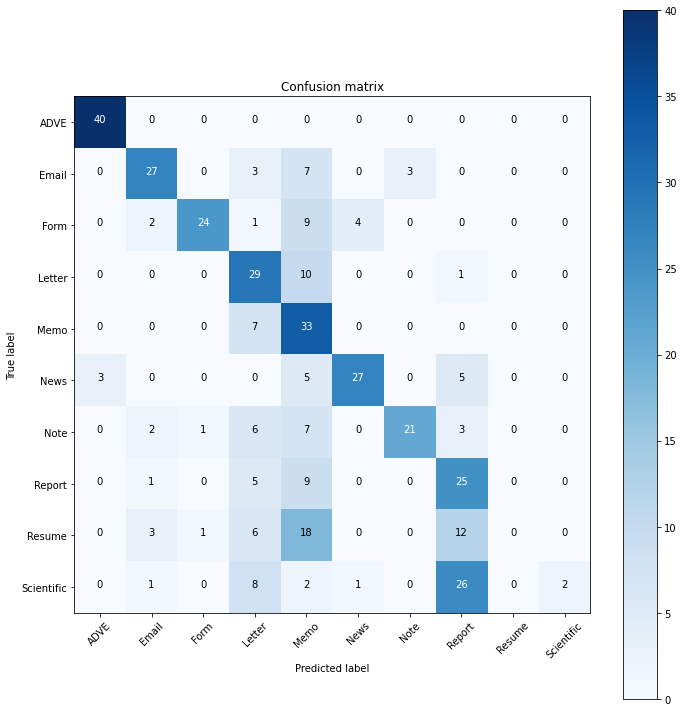

In [47]:
# Show confusion matrix
cm = confusion_matrix(labeltensor, train_preds.argmax(dim=1))
names = ('ADVE', 'Email', 'Form', 'Letter', 'Memo',
         'News', 'Note', 'Report', 'Resume', 'Scientific')
plt.figure(figsize=(10, 10))
plotcm.plot_confusion_matrix(cm, names)